# NOTEBOOK 1: APD DATA PIPELINE – CLEAN, SPATIAL, WEATHER, FEATURES, EDA

Save as: `01_wrangler.ipynb`

Pipeline:
1. Configuration, logging, paths
2. Standardize + combine raw APD CSVs
3. Clean columns, text, event_watch encoding
4. Robust date parsing
5. Spatial enrichment (NPU, zone, campus/neighborhood/city)
6. Campus proximity features (label, distance, codes, near_* flags)
7. Temporal & contextual features (semester, hour blocks, weekend, etc.)
8. Weather merge (2021–2025), flags (is_raining, is_hot, is_cold)
9. Filter target offenses & export modeling dataset
10. Final EDA + rich summary

In [ ]:
# === Imports =================================================================
# Required libraries:
# pip install numpy pandas geopandas matplotlib seaborn contextily python-dateutil holidays
# pip install shapely openmeteo-requests requests-cache retry-requests rich

import re
from math import radians, sin, cos, sqrt, asin
from pathlib import Path
from typing import List, Dict

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx

from dateutil import parser
import holidays

from shapely.geometry import Point

# Weather / API
import openmeteo_requests
import requests_cache
from retry_requests import retry

# Plotly (optional for extra EDA if you want later)
# import plotly.express as px
# import plotly.graph_objects as go

# Rich console
from rich.console import Console
from rich.table import Table
from rich.panel import Panel
from rich import print as rprint

console = Console()

console.print(
    Panel.fit(
        "[bold green]✓ Libraries Imported Successfully[/bold green]\n\n"
        "[cyan]Groups Loaded:[/cyan]\n"
        "• Core Python / Paths / Math\n"
        "• pandas / numpy / geopandas\n"
        "• matplotlib / seaborn / contextily\n"
        "• dateutil / holidays\n"
        "• shapely / sklearn-like patterns\n"
        "• open-meteo + requests-cache\n"
        "• Rich console for logs",
        title="[bold cyan]Import Summary[/bold cyan]",
        border_style="cyan",
    )
)

In [5]:
# === Pipeline Logger =========================================================

pipeline_log: List[Dict] = []

def log_step(step_name: str, df: pd.DataFrame) -> None:
    """Record a pipeline step with shape info."""
    if not isinstance(df, pd.DataFrame) or df.empty:
        rows, cols = "N/A", "N/A"
    else:
        rows, cols = df.shape[0], df.shape[1]

    pipeline_log.append({"step": step_name, "rows": rows, "cols": cols})
    console.print(f"[green]✓ {step_name}[/green] [cyan]→ shape: {rows:} × {cols}[/cyan]")


def show_pipeline_table() -> None:
    """Display a Rich table summarizing all pipeline steps."""
    if not pipeline_log:
        console.print("[red]No pipeline steps logged yet.[/red]")
        return

    table = Table(title="📊 Data Pipeline Summary", show_lines=True)
    table.add_column("Step", style="cyan", no_wrap=True)
    table.add_column("Rows", style="green")
    table.add_column("Cols", style="yellow")

    for entry in pipeline_log:
        table.add_row(entry["step"], f"{entry['rows']:,}", str(entry["cols"]))

    console.print(table)


console.print(Panel("[bold green]Pipeline Logger Configured[/bold green]"))
log_step("Step 0: Notebook initialized", pd.DataFrame())

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Pipeline Logger Configured                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

✓ Step 0: Notebook initialized → shape: N/A × N/A

In [6]:
# === Configuration: Paths, Shapefiles, Centers ===============================

DATA_DIR = Path("../data")
RAW_DATA_FOLDER = DATA_DIR / "raw" / "apd"
INTERIM_DATA_FOLDER = DATA_DIR / "interim" / "apd"
PROCESSED_DATA_FOLDER = DATA_DIR / "processed" / "apd"
EXTERNAL_DATA_FOLDER = DATA_DIR / "external"
SHAPEFILES_DIR = DATA_DIR / "raw" / "shapefiles"

EXTERNAL_DATA_FOLDER.mkdir(parents=True, exist_ok=True)
INTERIM_DATA_FOLDER.mkdir(parents=True, exist_ok=True)
PROCESSED_DATA_FOLDER.mkdir(parents=True, exist_ok=True)

# Weather CSVs written by fetch_atlanta_weather()
HOURLY_WEATHER_PATH = EXTERNAL_DATA_FOLDER / "atlanta_hourly_weather_2021_2025.csv"
DAILY_WEATHER_PATH = EXTERNAL_DATA_FOLDER / "atlanta_daily_weather_2021_2025.csv"

# Shapefiles (adjust names if your files differ)
CITIES_SHP = SHAPEFILES_DIR / "census_boundary_2024_sf" / "ga_census_places_2024.shp"
CAMPUS_SHP = SHAPEFILES_DIR / "area_landmark_2024_sf" / "ga_census_landmarks_2023.shp"
NEIGHBORHOOD_SHP = SHAPEFILES_DIR / "atl_neighborhood_sf" / "atl_neighborhoods.shp"
NPU_SHP = SHAPEFILES_DIR / "atl_npu_sf" / "atl_npu_boundaries.shp"
APD_ZONE_SHP = SHAPEFILES_DIR / "apd_zone_2019_sf" / "apd_police_zones_2019.shp"

# School center coordinates (lat, lon)
SCHOOL_CENTERS = {
    "GSU": (33.7530, -84.3863),
    "GA Tech": (33.7756, -84.3963),
    "Emory": (33.7925, -84.3239),
    "Clark": (33.7533, -84.4124),
    "Spelman": (33.7460, -84.4129),
    "Morehouse": (33.7483, -84.4126),
    "Morehouse Med": (33.7505, -84.4131),
    "Atlanta Metro": (33.7145, -84.4020),
    "Atlanta Tech": (33.7126, -84.4034),
    "SCAD": (33.7997, -84.3920),
    "John Marshall": (33.7621, -84.3896),
}

console.print(
    Panel.fit(
        f"[bold cyan]📁 Data Paths Configured[/bold cyan]\n\n"
        f"Raw Data: [yellow]{RAW_DATA_FOLDER}[/yellow]\n"
        f"Interim Data: [yellow]{INTERIM_DATA_FOLDER}[/yellow]\n"
        f"External Data: [yellow]{EXTERNAL_DATA_FOLDER}[/yellow]\n"
        f"Processed Data: [yellow]{PROCESSED_DATA_FOLDER}[/yellow]\n"
        f"Shapefiles: [yellow]{SHAPEFILES_DIR}[/yellow]"
    )
)

log_step("Step 1: Paths, settings, and constants configured", pd.DataFrame())

╭───────────────────────────────────────╮
│ 📁 Data Paths Configured              │
│                                       │
│ Raw Data: ../data/raw/apd             │
│ Interim Data: ../data/interim/apd     │
│ External Data: ../data/external       │
│ Processed Data: ../data/processed/apd │
│ Shapefiles: ../data/raw/shapefiles    │
╰───────────────────────────────────────╯

✓ Step 1: Paths, settings, and constants configured → shape: N/A × N/A

In [20]:
# === Weather Fetch (One-Time) ======================================

def fetch_atlanta_weather(
    start_date: str = "2021-01-01",
    end_date: str = "2025-11-30",
    lat: float = 33.749,
    lon: float = -84.388,
):
    """
    Fetches 2021–2025 Atlanta weather data from Open-Meteo archive and saves CSVs.
    Run once, then reuse CSVs.
    """
    console.print(
        Panel(
            f"[bold cyan]Fetching Weather Data[/bold cyan]\n"
            f"Location: ({lat:.3f}°N, {lon:.3f}°W)\n"
            f"Date Range: {start_date} to {end_date}",
            border_style="cyan",
        )
    )

    cache_session = requests_cache.CachedSession(".cache", expire_after=-1)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)

    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": [
            "temperature_2m",
            "precipitation",
            "rain",
            "apparent_temperature",
            "weather_code",
            "is_day",
        ],
        "daily": [
            "sunrise",
            "daylight_duration",
            "sunshine_duration",
            "precipitation_hours",
            "rain_sum",
            "temperature_2m_mean",
            "weather_code",
        ],
        "timezone": "America/New_York",
        "temperature_unit": "fahrenheit",
    }

    responses = openmeteo.weather_api(url, params=params)
    response = responses[0]

    hourly = response.Hourly()
    hourly_df = pd.DataFrame(
        {
            "datetime": pd.date_range(
                start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
                end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
                freq=pd.Timedelta(seconds=hourly.Interval()),
                inclusive="left",
            ),
            "temp_f": hourly.Variables(0).ValuesAsNumpy(),
            "precip_in": hourly.Variables(1).ValuesAsNumpy(),
            "rain_in": hourly.Variables(2).ValuesAsNumpy(),
            "apparent_temp_f": hourly.Variables(3).ValuesAsNumpy(),
            "weather_code_hrly": hourly.Variables(4).ValuesAsNumpy(),
            "is_daylight": hourly.Variables(5).ValuesAsNumpy().astype(int),
        }
    )
    hourly_df["datetime"] = (
        hourly_df["datetime"].dt.tz_convert("America/New_York").dt.tz_localize(None)
    )

    daily = response.Daily()
    daily_df = pd.DataFrame(
        {
            "date": pd.date_range(
                start=pd.to_datetime(daily.Time(), unit="s", utc=True),
                end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
                freq=pd.Timedelta(seconds=daily.Interval()),
                inclusive="left",
            ),
            "sunrise": daily.Variables(0).ValuesInt64AsNumpy(),
            "daylight_duration_sec": daily.Variables(1).ValuesAsNumpy(),
            "sunshine_duration_sec": daily.Variables(2).ValuesAsNumpy(),
            "precip_hours": daily.Variables(3).ValuesAsNumpy(),
            "rain_sum_in": daily.Variables(4).ValuesAsNumpy(),
            "temp_mean_f": daily.Variables(5).ValuesAsNumpy(),
            "weather_code_dy": daily.Variables(6).ValuesAsNumpy(),
        }
    )
    daily_df["date"] = (
        daily_df["date"]
        .dt.tz_convert("America/New_York")
        .dt.tz_localize(None)
        .dt.date
    )

    hourly_df.to_csv(HOURLY_WEATHER_PATH, index=False)
    daily_df.to_csv(DAILY_WEATHER_PATH, index=False)

    console.print(f"[green]✓ Saved hourly weather → {HOURLY_WEATHER_PATH}[/green]")
    console.print(f"[green]✓ Saved daily weather  → {DAILY_WEATHER_PATH}[/green]")
    console.print(
        f"[green]✓ Total rows: {len(hourly_df):,} hourly, {len(daily_df):,} daily[/green]"
    )

    return hourly_df, daily_df

# NOTE: Run this ONCE if you haven't created the weather CSVs yet.
fetch_atlanta_weather()
log_step("Step 2: Weather fetch function defined (run once if needed)", pd.DataFrame())

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Fetching Weather Data                                                                                           │
│ Location: (33.749°N, -84.388°W)                                                                                 │
│ Date Range: 2021-01-01 to 2025-11-30                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

✓ Saved hourly weather → ../data/external/atlanta_hourly_weather_2021_2025.csv

✓ Saved daily weather  → ../data/external/atlanta_daily_weather_2021_2025.csv

✓ Total rows: 43,080 hourly, 1,795 daily

✓ Step 2: Weather fetch function defined (run once if needed) → shape: N/A × N/A

In [8]:
# === Standardization & Combine ==============================================

def standardize_column_name(col: str) -> str:
    """Convert column name to snake_case format."""
    col = re.sub(r"(.)([A-Z][a-z]+)", r"\1_\2", col)
    col = re.sub(r"([a-z0-9])([A-Z])", r"\1_\2", col)
    col = col.lower()
    col = re.sub(r"[\s\-\.\,\(\)\[\]\{\}]+", "_", col)
    col = re.sub(r"[^\w]", "", col)
    col = re.sub(r"_+", "_", col).strip("_")
    return col


def combine_and_deduplicate(files: List[Path], dedupe_key: str) -> pd.DataFrame:
    """Combine multiple CSVs, standardize columns, and drop duplicates."""
    console.print("\n[bold cyan]═══ Combining Data Files ═══[/bold cyan]\n")

    dfs = []
    for filepath in files:
        console.print(f"[cyan]Reading and standardizing:[/cyan] {filepath.name}")
        df = pd.read_csv(filepath)
        df.columns = [standardize_column_name(c) for c in df.columns]
        dfs.append(df)

    df_combined = pd.concat(dfs, ignore_index=True)
    total_rows = len(df_combined)

    if dedupe_key not in df_combined.columns:
        raise KeyError(
            f"dedupe_key='{dedupe_key}' not found in columns: {df_combined.columns.tolist()}"
        )

    log_step("Ingest Raw Data", df_combined)

    df_dedup = df_combined.drop_duplicates(subset=[dedupe_key])
    duplicates = total_rows - len(df_dedup)

    console.print(f"[yellow]Combined:[/] {total_rows:,} rows")
    console.print(f"[red]Removed:[/] {duplicates:,} duplicate rows")

    log_step("Step 3: Standardize & Combine", df_dedup)
    return df_dedup


console.print("[bold cyan]Scanning RAW_DATA_FOLDER for APD CSVs...[/bold cyan]")
input_files = list(RAW_DATA_FOLDER.glob("*.csv"))

if not input_files:
    console.print(
        f"[bold red]Warning:[/bold red] No CSV files found in '{RAW_DATA_FOLDER}'"
    )
    df_combined = pd.DataFrame()
else:
    console.print(f"[bold cyan]Found {len(input_files)} CSV file(s).[/bold cyan]")
    df_combined = combine_and_deduplicate(
        files=input_files, dedupe_key="incident_number"
    )

Scanning RAW_DATA_FOLDER for APD CSVs...

Found 3 CSV file(s).

═══ Combining Data Files ═══

Reading and standardizing: apd_2020_2024.csv

Reading and standardizing: apd_2023_2025.csv

Reading and standardizing: apd_2021_2024.csv

✓ Ingest Raw Data → shape: 372864 × 28

Combined: 372,864 rows

Removed: 106,903 duplicate rows

✓ Step 3: Standardize & Combine → shape: 265961 × 28

In [9]:
# === Cleaning: Drop, Rename, Text, event_watch OHE ==========================

def clean_apd_data(df: pd.DataFrame) -> pd.DataFrame:
    """Drop unnecessary columns, normalize text, and one-hot encode event_watch."""
    console.print("\n[bold cyan]═══ Cleaning Data ═══[/bold cyan]\n")

    df = df.copy()

    # Drops (adjust as needed)
    columns_to_drop = [
        "report_number",
        "zone",
        "fire_arm_involved",
        "object_id",
        "occurred_from_date",
        "occurred_to_date",
        "part",
        "vic_count",
        "is_bias_motivation_involved",
        "x",
        "y",
        "beat_text",
    ]

    existing_drops = [col for col in columns_to_drop if col in df.columns]
    if existing_drops:
        df = df.drop(columns=existing_drops)
        console.print(
            f"[yellow]Dropped {len(existing_drops)} columns:[/yellow] {', '.join(existing_drops)}"
        )

    # Renames
    if "objectid" in df.columns:
        df = df.rename(columns={"objectid": "object_id"})
    if "nhood_name" in df.columns:
        df = df.rename(columns={"nhood_name": "neighborhood"})

    # One-hot encode event_watch
    if "event_watch" in df.columns:
        console.print("[cyan]One-hot encoding:[/cyan] 'event_watch'")
        one_hot = pd.get_dummies(df["event_watch"], prefix="event_watch", dummy_na=False)
        one_hot.columns = [standardize_column_name(col) for col in one_hot.columns]
        df = pd.concat([df.drop(columns=["event_watch"]), one_hot], axis=1)
        console.print(
            f"[green]✓[/green] Created {len(one_hot.columns)} standardized event_watch OHE columns"
        )

    # Lowercase some text columns
    text_columns = ["location_type", "street_address", "nibrs_offense"]
    for col in text_columns:
        if col in df.columns:
            df[col] = df[col].astype(str).str.lower()

    log_step("Step 4: Clean & Drop Columns", df)
    return df


df_clean = clean_apd_data(df_combined)

═══ Cleaning Data ═══

Dropped 11 columns: report_number, zone, fire_arm_involved, occurred_from_date, occurred_to_date, part, vic_count, 
is_bias_motivation_involved, x, y, beat_text

One-hot encoding: 'event_watch'

✓ Created 3 standardized event_watch OHE columns

✓ Step 4: Clean & Drop Columns → shape: 265961 × 19

In [10]:
# === Robust Date Parsing ======================================================

console.print(
    "\n[bold cyan]═══ Standardizing 'report_date' Column (Robust Parser) ═══[/bold cyan]\n"
)

df_clean["_raw_report_date"] = df_clean["report_date"].astype(str).str.strip()
total_rows = len(df_clean)


def parse_report_date(x):
    """Safely parse mixed APD/NIBRS date formats."""
    if pd.isna(x):
        return pd.NaT

    x = str(x).strip()

    # Specific patterns first
    if re.match(r"^\d{1,2}/\d{1,2}/\d{4} \d{1,2}:\d{2}:\d{2} [APMapm]{2}$", x):
        return pd.to_datetime(x, format="%m/%d/%Y %I:%M:%S %p", errors="coerce")
    if re.match(r"^\d{1,2}/\d{1,2}/\d{4} \d{1,2}:\d{2} [APMapm]{2}$", x):
        return pd.to_datetime(x, format="%m/%d/%Y %I:%M %p", errors="coerce")
    if re.match(r"^\d{1,2}/\d{1,2}/\d{4} \d{1,2}:\d{2}$", x):
        return pd.to_datetime(x, format="%m/%d/%Y %H:%M", errors="coerce")

    # Fallback
    try:
        return parser.parse(x, fuzzy=True)
    except Exception:
        return pd.NaT


df_clean["report_date"] = df_clean["_raw_report_date"].apply(parse_report_date)
invalid = df_clean["report_date"].isna().sum()
parsed = total_rows - invalid

console.print(f"[cyan]Total rows: {total_rows:,}[/cyan]")
console.print(f"[green]Successfully standardized: {parsed:,}[/green]")
console.print(f"[yellow]Unrecoverable dates dropped: {invalid:,}[/yellow]")

df_clean = df_clean.dropna(subset=["report_date"]).copy()
df_clean["report_date"] = pd.to_datetime(df_clean["report_date"])

log_step("Step 5: Robust Date Standardization", df_clean)

console.print("\n[bold blue]Examples of Corrected Formats:[/bold blue]")
changed = df_clean[
    df_clean["_raw_report_date"] != df_clean["report_date"].astype(str)
]
if len(changed) > 0:
    console.print(
        changed.sample(min(5, len(changed)))[["_raw_report_date", "report_date"]]
    )
else:
    console.print("[yellow]All dates already standardized.[/yellow]")

═══ Standardizing 'report_date' Column (Robust Parser) ═══

Total rows: 265,961

Successfully standardized: 265,961

Unrecoverable dates dropped: 0

✓ Step 5: Robust Date Standardization → shape: 265961 × 20

Examples of Corrected Formats:

_raw_report_date         report_date
93115   6/22/2022 5:03:39 PM 2022-06-22 17:03:39
178833  4/23/2024 1:37:02 AM 2024-04-23 01:37:02
171371  1/16/2024 4:53:28 PM 2024-01-16 16:53:28
348508       9/24/2025 16:13 2025-09-24 16:13:00
49261   9/23/2021 1:09:29 AM 2021-09-23 01:09:29

In [11]:
# === Spatial Helpers: Haversine & GeoDataFrame ===============================

def haversine_distance(lon1, lat1, lon2, lat2, unit: str = "miles"):
    """Great-circle distance between two points."""
    R = 3956 if unit == "miles" else 6371000  # miles or meters
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    return R * c


def calculate_nearest_campus_distance(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates:
      • dist_gsu_miles (for GSU specifically)
      • nearest_campus_temp + campus_distance_m_temp (meters to nearest campus)
    """
    df = df.copy()
    console.print("[cyan]Calculating campus distances...[/cyan]")

    # dist_gsu_miles
    gsu_lat, gsu_lon = SCHOOL_CENTERS["GSU"]
    df["dist_gsu_miles"] = df.apply(
        lambda row: haversine_distance(
            row["longitude"], row["latitude"], gsu_lon, gsu_lat, unit="miles"
        )
        if pd.notna(row["longitude"]) and pd.notna(row["latitude"])
        else np.nan,
        axis=1,
    )

    # nearest_campus_temp + campus_distance_m_temp
    def find_nearest_campus(row):
        if pd.isna(row["longitude"]) or pd.isna(row["latitude"]):
            return ("none", np.nan)

        min_dist = float("inf")
        nearest = "none"

        for campus, (c_lat, c_lon) in SCHOOL_CENTERS.items():
            dist_m = haversine_distance(
                row["longitude"], row["latitude"], c_lon, c_lat, unit="meters"
            )
            if dist_m < min_dist:
                min_dist = dist_m
                nearest = campus

        return nearest, min_dist

    df[["nearest_campus_temp", "campus_distance_m_temp"]] = df.apply(
        find_nearest_campus, axis=1, result_type="expand"
    )

    console.print(
        "[green]✓ 'dist_gsu_miles', 'nearest_campus_temp', 'campus_distance_m_temp' computed[/green]"
    )
    return df


def to_gdf(
    df: pd.DataFrame, lon_col: str = "longitude", lat_col: str = "latitude"
) -> gpd.GeoDataFrame:
    """Convert DataFrame with lon/lat into GeoDataFrame in EPSG:4326."""
    for c in (lon_col, lat_col):
        if c not in df.columns:
            raise KeyError(f"Expected coordinate column '{c}' not found.")
    return gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df[lon_col], df[lat_col]),
        crs="EPSG:4326",
    )


def load_shapefile(path: Path, target_crs) -> gpd.GeoDataFrame:
    """Load shapefile and ensure CRS alignment."""
    try:
        gdf = gpd.read_file(path)
    except Exception:
        console.print(
            f"[bold red]FATAL ERROR:[/bold red] Could not load shapefile: {path}",
        )
        raise

    if gdf.crs is None:
        gdf = gdf.set_crs("EPSG:4326")
    return gdf.to_crs(target_crs)

In [12]:
# === Spatial Attach Functions ================================================

def attach_campus(gdf: gpd.GeoDataFrame, campus_shp: Path) -> gpd.GeoDataFrame:
    """Attach closest campus label (educational landmarks)."""
    console.print("[cyan]Attaching campus labels...[/cyan]")
    campus = load_shapefile(campus_shp, gdf.crs)
    if "MTFCC" in campus.columns:
        campus = campus[campus["MTFCC"] == "S1400"]  # educational
    name_col = "FULLNAME" if "FULLNAME" in campus.columns else campus.columns[0]
    campus = campus[[name_col, "geometry"]].rename(columns={name_col: "campus_label"})
    gdf = gpd.sjoin_nearest(gdf, campus, how="left")
    gdf = gdf.drop(columns=["index_right"], errors="ignore")
    return gdf


def attach_neighborhood(
    gdf: gpd.GeoDataFrame, nhood_shp: Path
) -> gpd.GeoDataFrame:
    console.print("[cyan]Attaching neighborhood labels...[/cyan]")
    nhoods = load_shapefile(nhood_shp, gdf.crs)
    name_col = "NAME" if "NAME" in nhoods.columns else nhoods.columns[0]
    nhoods = nhoods[[name_col, "geometry"]].rename(
        columns={name_col: "neighborhood_label"}
    )
    gdf = gpd.sjoin(gdf, nhoods, how="left", predicate="within")
    gdf = gdf.drop(columns=["index_right"], errors="ignore")
    return gdf


def attach_city(gdf: gpd.GeoDataFrame, cities_shp: Path) -> gpd.GeoDataFrame:
    console.print("[cyan]Attaching city labels...[/cyan]")
    cities = load_shapefile(cities_shp, gdf.crs)
    name_col = "NAME" if "NAME" in cities.columns else cities.columns[0]
    cities = cities[[name_col, "geometry"]].rename(columns={name_col: "city_label"})
    gdf = gpd.sjoin(gdf, cities, how="left", predicate="within")
    gdf = gdf.drop(columns=["index_right"], errors="ignore")
    return gdf


def attach_npu(gdf: gpd.GeoDataFrame, npu_shp: Path) -> gpd.GeoDataFrame:
    console.print("[cyan]Attaching NPU labels...[/cyan]")
    npu = load_shapefile(npu_shp, gdf.crs)
    name_col = "NAME" if "NAME" in npu.columns else "NPU"
    npu = npu[[name_col, "geometry"]].rename(columns={name_col: "npu_label"})
    gdf = gpd.sjoin_nearest(gdf, npu, how="left")
    gdf = gdf.drop(columns=["index_right"], errors="ignore")
    return gdf


def attach_apd_zone(gdf: gpd.GeoDataFrame, zone_shp: Path) -> gpd.GeoDataFrame:
    console.print("[cyan]Attaching APD zones...[/cyan]")
    zones = load_shapefile(zone_shp, gdf.crs)
    zone_col = "ZONE" if "ZONE" in zones.columns else zones.columns[0]
    zones = zones[[zone_col, "geometry"]].rename(columns={zone_col: "zone_raw"})
    gdf = gpd.sjoin(gdf, zones, how="left", predicate="within")
    gdf = gdf.drop(columns=["index_right"], errors="ignore")
    gdf["zone_int"] = pd.to_numeric(
        gdf["zone_raw"].astype(str).str.extract(r"(\d+)", expand=False),
        errors="coerce",
    )
    return gdf


def impute_missing_zone_from_npu(df: pd.DataFrame) -> pd.DataFrame:
    """Impute missing zone_int using mode zone per NPU."""
    if "zone_int" not in df.columns or "npu_label" not in df.columns:
        return df

    missing_before = df["zone_int"].isna().sum()
    if missing_before == 0:
        return df

    mapping = (
        df.dropna(subset=["zone_int"])
        .groupby("npu_label")["zone_int"]
        .apply(lambda s: s.mode().iloc[0] if not s.mode().empty else np.nan)
    )

    df["zone_int"] = df["zone_int"].fillna(df["npu_label"].map(mapping))
    missing_after = df["zone_int"].isna().sum()

    console.print(
        f"[green]✓ Imputed {missing_before - missing_after} zone_int via NPU mode[/green]"
    )
    return df


def build_location_label(df: pd.DataFrame) -> pd.DataFrame:
    """Build prioritized location_label from campus/neighborhood/city."""
    df = df.copy()
    conditions = [
        df.get("campus_label").notna() if "campus_label" in df.columns else False,
        df.get("neighborhood_label").notna()
        if "neighborhood_label" in df.columns
        else False,
        df.get("city_label").notna() if "city_label" in df.columns else False,
    ]
    choices = [
        df.get("campus_label"),
        df.get("neighborhood_label"),
        df.get("city_label"),
    ]
    df["location_label"] = np.select(conditions, choices, default="Other")
    return df

In [13]:
# === Campus Proximity Finalization (label, distance, code, near_*) ===========

def finalize_campus_proximity(df: pd.DataFrame) -> pd.DataFrame:
    """
    Uses nearest_campus_temp & campus_distance_m_temp to:
      • enforce a 1.5-mile (2414 m) threshold
      • define campus_label, campus_distance_m
      • create campus_code (0 = none)
      • create binary near_<campus> flags
    """
    df = df.copy()
    console.print(
        Panel("[bold cyan]Finalizing campus proximity features[/bold cyan]")
    )

    DISTANCE_THRESHOLD_M = 2414.016

    # Start from temp columns created earlier
    label = df["nearest_campus_temp"].fillna("none").astype(str)
    dist_m = df["campus_distance_m_temp"]

    # Apply threshold
    label = np.where(
        (dist_m.notna()) & (dist_m <= DISTANCE_THRESHOLD_M), label, "none"
    )
    dist_m = np.where(
        (dist_m.notna()) & (dist_m <= DISTANCE_THRESHOLD_M), dist_m, np.nan
    )

    df["campus_label"] = label
    df["campus_distance_m"] = dist_m

    CAMPUS_ENCODING = {
        "none": 0,
        "GSU": 1,
        "GA Tech": 2,
        "Emory": 3,
        "Clark": 4,
        "Spelman": 5,
        "Morehouse": 6,
        "Morehouse Med": 7,
        "Atlanta Metro": 8,
        "Atlanta Tech": 9,
        "SCAD": 10,
        "John Marshall": 11,
    }
    df["campus_code"] = (
        df["campus_label"].map(CAMPUS_ENCODING).fillna(0).astype(int)
    )

    # near_<campus> binary indicators
    for campus in SCHOOL_CENTERS.keys():
        col = f"near_{campus.lower().replace(' ', '_')}"
        df[col] = (df["campus_label"] == campus).astype(int)

    kept = (df["campus_label"] != "none").sum()
    console.print(
        f"[green]✓ Assigned campus proximity to {kept:,} crimes within 1.5 miles[/green]"
    )
    console.print(
        "[green]✓ campus_code, campus_distance_m, near_* flags created[/green]"
    )

    # Drop temps
    df = df.drop(
        columns=["nearest_campus_temp", "campus_distance_m_temp"], errors="ignore"
    )
    return df

In [15]:
# === Spatial Enrichment Wrapper ==============================================

def enrich_spatial(df: pd.DataFrame) -> pd.DataFrame:
    """
    Spatial pipeline:
      • drop rows without coords
      • campus distance (GSU + nearest campus)
      • project to 3857
      • attach NPU, APD zone, campus, neighborhood, city
      • impute missing zones via NPU
      • build location_label
      • finalize campus proximity features
    """
    console.print("\n[bold cyan]═══ Spatial Enrichment ═══[/bold cyan]\n")

    df = df.copy()
    initial_count = len(df)
    df_temp = df.dropna(subset=["longitude", "latitude"]).copy()
    dropped = initial_count - len(df_temp)
    if dropped > 0:
        console.print(
            f"[yellow]Dropped {dropped} rows missing coordinates for spatial enrichment[/yellow]"
        )

    # Campus distance (miles + temp nearest)
    df_temp = calculate_nearest_campus_distance(df_temp)

    # To GeoDataFrame (4326 → 3857)
    gdf = to_gdf(df_temp, lon_col="longitude", lat_col="latitude")
    TARGET_CRS = "EPSG:3857"
    gdf = gdf.to_crs(TARGET_CRS)
    console.print(f"[green]✓ Projected to {TARGET_CRS}[/green]")

    # Attach polygons
    gdf = attach_npu(gdf, NPU_SHP)
    gdf = attach_apd_zone(gdf, APD_ZONE_SHP)
    gdf = attach_campus(gdf, CAMPUS_SHP)
    gdf = attach_neighborhood(gdf, NEIGHBORHOOD_SHP)
    gdf = attach_city(gdf, CITIES_SHP)

    # Back to DataFrame
    df_enriched = pd.DataFrame(
        gdf.drop(columns=["geometry", "zone_raw"], errors="ignore")
    )

    # Impute zone_int via NPU
    df_enriched = impute_missing_zone_from_npu(df_enriched)

    # Location label
    df_enriched = build_location_label(df_enriched)

    # Campus proximity finalization (label, distance, code, near_*)
    df_enriched = finalize_campus_proximity(df_enriched)

    log_step("Step 6: Spatial Enrichment + Campus Proximity", df_enriched)
    return df_enriched


df_spatial = enrich_spatial(df_clean)

# Rename raw date column for clarity
if "_raw_report_date" in df_spatial.columns:
    df_spatial = df_spatial.rename(
        columns={"_raw_report_date": "raw_report_date"}
    )
    console.print("[green]✓ Renamed '_raw_report_date' → 'raw_report_date'[/green]")
log_step("Step 7: Raw date column renamed", df_spatial)

═══ Spatial Enrichment ═══

Calculating campus distances...

✓ 'dist_gsu_miles', 'nearest_campus_temp', 'campus_distance_m_temp' computed

✓ Projected to EPSG:3857

Attaching NPU labels...

Attaching APD zones...

Attaching campus labels...

Attaching neighborhood labels...

Attaching city labels...

✓ Imputed 2175 zone_int via NPU mode

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Finalizing campus proximity features                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

✓ Assigned campus proximity to 125,153 crimes within 1.5 miles

✓ campus_code, campus_distance_m, near_* flags created

✓ Step 6: Spatial Enrichment + Campus Proximity → shape: 265965 × 39

✓ Renamed '_raw_report_date' → 'raw_report_date'

✓ Step 7: Raw date column renamed → shape: 265965 × 39

In [16]:
# === Holidays & Temporal / Contextual Features ==================================

def add_holiday_flag(
    df: pd.DataFrame, date_col: str = "report_date", country: str = "US", subdiv: str = "GA"
) -> pd.DataFrame:
    """Adds is_holiday boolean based on US-GA holidays."""
    df = df.copy()
    years = sorted(df[date_col].dt.year.unique().tolist())
    console.print(
        f"[cyan]Generating holidays for {country}-{subdiv} years={years}[/cyan]"
    )
    holiday_dates = holidays.country_holidays(
        country=country, subdiv=subdiv, years=years
    )
    holiday_set = {d for d in holiday_dates.keys()}

    df["_date_only"] = df[date_col].dt.date
    df["is_holiday"] = df["_date_only"].isin(holiday_set)
    df = df.drop(columns=["_date_only"])
    console.print("[green]✓ 'is_holiday' column created[/green]")
    return df


def engineer_date_context_features(
    df: pd.DataFrame, date_col: str = "report_date"
) -> pd.DataFrame:
    """
    Create core temporal + contextual features:
      • incident_datetime, incident_date, incident_hour
      • day_of_week, day_number (Mon=1…Sun=7), day_of_year, week_number
      • year, month
      • semester (Fall/Spring/Summer)
      • hour_block (6 x 4-hour bins)
      • is_weekend
      • loc_acc (1 if missing coords)
      • offense_category, nibrs_code
      • is_holiday
    """
    df = df.copy()
    console.print(
        "\n[bold cyan]═══ Engineering Date & Contextual Features ═══[/bold cyan]\n"
    )

    df[date_col] = pd.to_datetime(df[date_col])
    dt = df[date_col].dt

    # Core temporal
    df["incident_datetime"] = df[date_col]
    df["incident_date"] = dt.date
    df["incident_hour"] = dt.hour
    df["incident_datetime_hour"] = dt.to_period("h").astype(str)
    df["day_of_week"] = dt.day_name()

    # MEDIUM-VALUE: day_number / day_of_year / week_number
    df["day_number"] = dt.weekday + 1  # Monday=1 ... Sunday=7
    df["day_of_year"] = dt.dayofyear
    df["week_number"] = dt.isocalendar().week.astype(int)

    df["year"] = dt.year
    df["month"] = dt.month

    # Semester (HIGH-VALUE)
    month = dt.month
    df["semester"] = np.select(
        [month.isin([8, 9, 10, 11, 12]), month.isin([1, 2, 3, 4, 5])],
        ["Fall", "Spring"],
        default="Summer",
    )

    # Hour blocks (HIGH-VALUE 6 x 4-hour bins)
    bins = [0, 5, 9, 13, 17, 21, 25]
    labels = [
        "Early Night (0–4)",
        "Early Morning (5–8)",
        "Late Morning (9–12)",
        "Afternoon (13–16)",
        "Evening (17–20)",
        "Late Night (21–24)",
    ]
    df["hour_block"] = pd.cut(df["incident_hour"], bins=bins, labels=labels, right=False)

    # Weekend flag (HIGH-VALUE)
    df["is_weekend"] = dt.weekday >= 5

    # Location accuracy (HIGH-VALUE)
    df["loc_acc"] = np.where(
        df["latitude"].isna() | df["longitude"].isna(), 1, 0
    )

    # Offense category (HIGH-VALUE)
    if "nibrs_ucr_code" in df.columns:
        df["nibrs_code"] = df["nibrs_ucr_code"]

    if "nibrs_offense" in df.columns:
        df["offense_category"] = np.select(
            [
                df["nibrs_offense"].str.contains(
                    "burglary|robbery", case=False, na=False
                ),
                df["nibrs_offense"].str.contains(
                    "motor vehicle theft", case=False, na=False
                ),
                df["nibrs_offense"].str.contains(
                    "theft|larceny|shoplift|fraud|swindle|embezzelment|stolen property|false pretenses",
                    case=False,
                    na=False,
                ),
                df["nibrs_offense"].str.contains(
                    "assault|murder|rape|battery|intimidation|extortion|kidnapping",
                    case=False,
                    na=False,
                ),
            ],
            [
                "Burglary/Robbery",
                "Motor Vehicle Theft",
                "Theft/Larceny/Fraud",
                "Violent Crime",
            ],
            default="Other/Misc.",
        )

    # Holidays (HIGH-VALUE context)
    df = add_holiday_flag(df, date_col=date_col)

    log_step("Step 8: Date & Context Features", df)
    return df


df_features = engineer_date_context_features(df_spatial)

═══ Engineering Date & Contextual Features ═══

Generating holidays for US-GA years=[2021, 2022, 2023, 2024, 2025]

✓ 'is_holiday' column created

✓ Step 8: Date & Context Features → shape: 265965 × 55

In [21]:
# === Weather Merge + Flags ====================================================

def merge_weather_data(df: pd.DataFrame) -> pd.DataFrame:
    """Merge hourly + daily weather into APD data."""
    df = df.copy()
    console.print("\n[bold cyan]═══ Merging Weather Data ═══[/bold cyan]")

    try:
        hourly_df = pd.read_csv(HOURLY_WEATHER_PATH)
        daily_df = pd.read_csv(DAILY_WEATHER_PATH)
    except FileNotFoundError:
        console.print(
            "[bold red]WARNING:[/bold red] Weather CSVs not found. Run fetch_atlanta_weather() first."
        )
        return df

    df["report_date_dt"] = pd.to_datetime(df["report_date"])
    hourly_df["datetime"] = pd.to_datetime(hourly_df["datetime"])
    daily_df["date"] = pd.to_datetime(daily_df["date"])

    # Hourly merge (floor to hour)
    df = df.merge(
        hourly_df,
        left_on=df["report_date_dt"].dt.floor("H"),
        right_on=hourly_df["datetime"].dt.floor("H"),
        how="left",
    )
    df = df.drop(columns=["key_0"], errors="ignore")

    # Daily merge (by date_only)
    df["date_only"] = df["report_date_dt"].dt.date
    daily_df["date_only"] = daily_df["date"].dt.date

    df = df.merge(
        daily_df.drop(columns=["date"]),
        on="date_only",
        how="left",
        suffixes=("_hourly", "_daily"),
    )

    df = df.drop(columns=["report_date_dt", "date_only", "datetime"], errors="ignore")
    console.print("[green]✓ Hourly + Daily weather merged[/green]")

    log_step("Step 9: Weather Merge", df)
    return df


def derive_weather_flags(df: pd.DataFrame) -> pd.DataFrame:
    """
    MEDIUM + HIGH VALUE:
      • is_raining from precip_in
      • is_hot / is_cold from percentile thresholds of temp_f
    """
    df = df.copy()
    console.print(
        "\n[bold cyan]═══ Deriving Weather Flags (is_raining, is_hot, is_cold) ═══[/bold cyan]"
    )

    temp_col = "temp_f"
    precip_col = "precip_in"

    if temp_col not in df.columns or precip_col not in df.columns:
        console.print(
            f"[yellow]Missing {temp_col} or {precip_col}; skipping weather flags.[/yellow]"
        )
        return df

    # MEDIUM-VALUE: is_raining flag
    df["is_raining"] = (df[precip_col].fillna(0) > 0.01).astype(int)

    # HIGH-VALUE: percentile thresholds for is_hot / is_cold
    p85 = df[temp_col].quantile(0.85)
    p15 = df[temp_col].quantile(0.15)

    console.print(f"[cyan]85th percentile temp_f: {p85:.1f}°F[/cyan]")
    console.print(f"[cyan]15th percentile temp_f: {p15:.1f}°F[/cyan]")

    df["is_hot"] = (df[temp_col] >= p85).astype(int)
    df["is_cold"] = (df[temp_col] <= p15).astype(int)

    hot_pct = (df["is_hot"] == 1).mean() * 100
    cold_pct = (df["is_cold"] == 1).mean() * 100

    console.print(
        f"[green]✓ is_hot (≥{p85:.1f}°F): {hot_pct:.1f}% of records[/green]"
    )
    console.print(
        f"[green]✓ is_cold (≤{p15:.1f}°F): {cold_pct:.1f}% of records[/green]"
    )

    log_step("Step 10: Weather Flags", df)
    return df


df_features = merge_weather_data(df_features)
df_features = derive_weather_flags(df_features)

═══ Merging Weather Data ═══

/tmp/ipykernel_24495/843789860.py:24: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  left_on=df["report_date_dt"].dt.floor("H"),
/tmp/ipykernel_24495/843789860.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  right_on=hourly_df["datetime"].dt.floor("H"),


✓ Hourly + Daily weather merged

✓ Step 9: Weather Merge → shape: 265994 × 68

═══ Deriving Weather Flags (is_raining, is_hot, is_cold) ═══

85th percentile temp_f: 79.2°F

15th percentile temp_f: 45.7°F

✓ is_hot (≥79.2°F): 15.0% of records

✓ is_cold (≤45.7°F): 15.1% of records

✓ Step 10: Weather Flags → shape: 265994 × 71

In [22]:
# === Filter Target Offenses & Export =========================================

console.print(
    "\n[bold cyan]═══ Final Filtering & Export (Target Offenses) ═══[/bold cyan]\n"
)

TARGET_OFFENSES = [
    "larceny",
    "theft",
    "robbery",
    "burglary",
    "prowling",
    "shoplifting",
    "fraud",
    "swindle",
    "embezzelment",
    "credit card",
    "wire fraud",
    "impersonation",
]

if "nibrs_offense" not in df_features.columns:
    raise KeyError("'nibrs_offense' column not found; cannot filter TARGET_OFFENSES.")

mask = df_features["nibrs_offense"].str.contains(
    "|".join(TARGET_OFFENSES), case=False, na=False
)
df_model = df_features[mask].copy()

if "raw_report_date" in df_model.columns:
    df_model = df_model.drop(columns=["raw_report_date"])
    console.print("[yellow]Dropped 'raw_report_date' before export[/yellow]")

log_step("Step 11: Filter for Target Crimes", df_model)
console.print(
    f"[bold yellow]Filtered for Modeling:[/bold yellow] {len(df_model):,} rows match target offenses."
)

df_final = df_model.sort_values("report_date", ascending=True, ignore_index=True)

final_output = INTERIM_DATA_FOLDER / "apd_model_data_target_crimes.csv"
df_final.to_csv(final_output, index=False)

log_step("Step 12: Interim Data Export", df_final)
console.print(f"[bold green]✓ Exported modeling dataset → {final_output}[/bold green]")
console.print(
    f"[bold]Final dataset:[/bold] {len(df_final):,} rows × {df_final.shape[1]} columns"
)

═══ Final Filtering & Export (Target Offenses) ═══

Dropped 'raw_report_date' before export

✓ Step 11: Filter for Target Crimes → shape: 117756 × 70

Filtered for Modeling: 117,756 rows match target offenses.

✓ Step 12: Interim Data Export → shape: 117756 × 70

✓ Exported modeling dataset → ../data/interim/apd/apd_model_data_target_crimes.csv

Final dataset: 117,756 rows × 70 columns

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Step 13: Final EDA Summary Checks                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

EDA Dataset Loaded: 117,756 rows × 70 columns

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Top 20 Missing Columns                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

missing      %
campus_distance_m     63126  53.61
neighborhood           8172   6.94
neighborhood_label     7964   6.76
district               4321   3.67
npu                    4320   3.67
city_label              962   0.82
weather_code_hrly         9   0.01
is_daylight               9   0.01
temp_f                    9   0.01
precip_in                 9   0.01
rain_in                   9   0.01
apparent_temp_f           9   0.01
incident_number           0   0.00
object_id                 0   0.00
crime_against             0   0.00
day_number                0   0.00
day_of_the_week           0   0.00
report_date               0   0.00
zone_int                  0   0.00
latitude                  0   0.00

Duplicate Rows: 0

Duplicate incident_number rows: 7

Latitude range: 28.067642 → 40.607613

Longitude range: -84.78213 → -74.117852

Zero lat rows: 0

Zero lon rows: 0

Offense Category Breakdown

offense_category
Theft/Larceny/Fraud    84686
Motor Vehicle Theft    17629
Burglary/Robbery       11579
Other/Misc.             3862
Name: count, dtype: int64

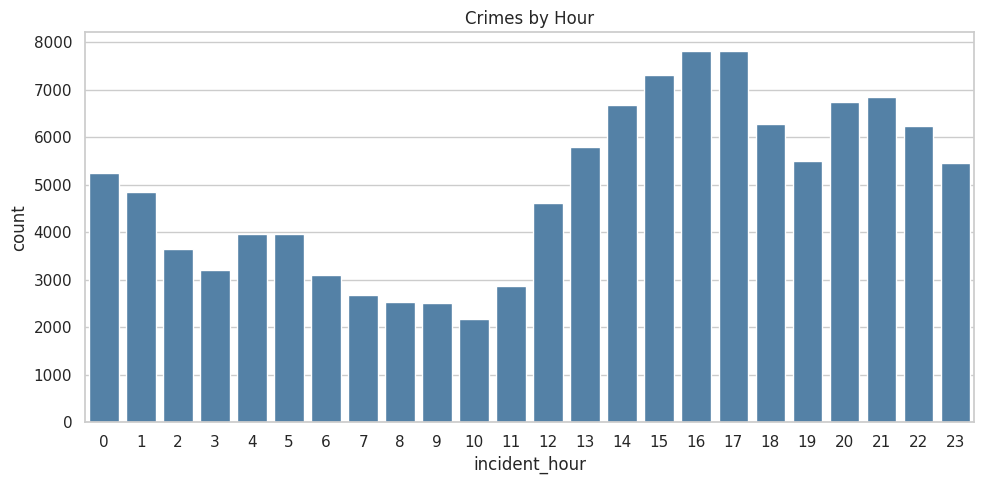

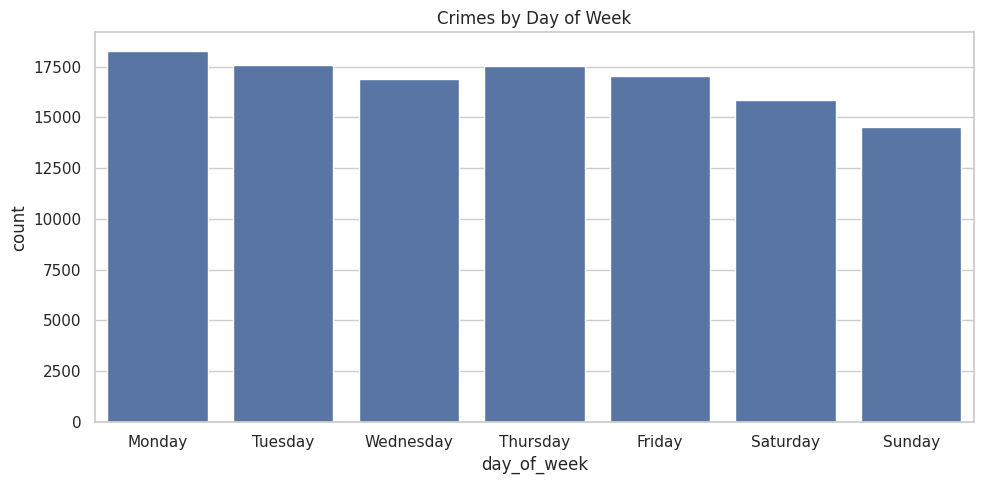

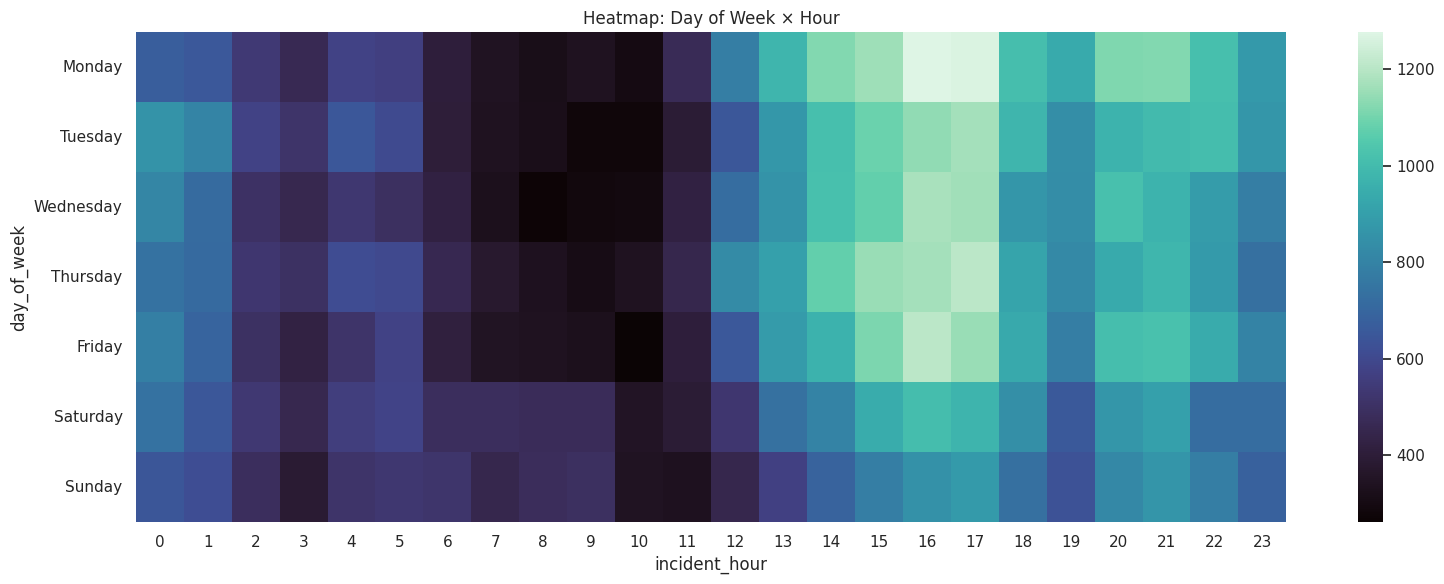

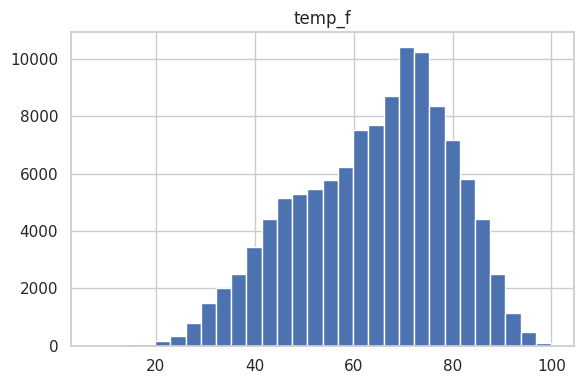

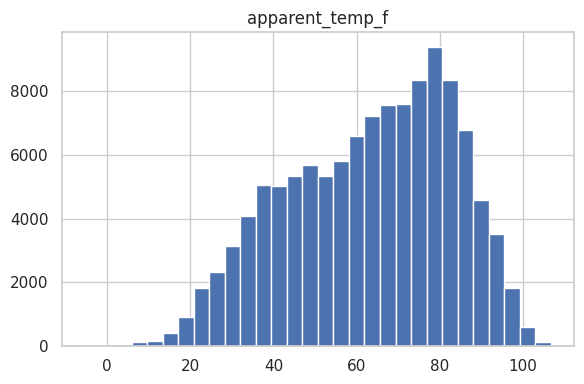

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Step 14: Comprehensive Crime Statistics Summary                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

  COMPREHENSIVE CRIME STATISTICS SUMMARY  
               (2021–2025)                
┌──────────────┬─────────────────────────┐
│ Total Crimes │ 117,756                 │
├──────────────┼─────────────────────────┤
│ Date Range   │ 2021-01-01 → 2025-11-27 │
└──────────────┴─────────────────────────┘

        📊 Temporal Insights         
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓
┃ Time Metric ┃ Peak Value ┃  Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩
│ Peak Hour   │ 16:00      │  7,817 │
├─────────────┼────────────┼────────┤
│ Peak Day    │ Monday     │ 18,277 │
├─────────────┼────────────┼────────┤
│ Peak Month  │ Oct        │ 10,580 │
├─────────────┼────────────┼────────┤
│ Peak Year   │ 2023       │ 25,456 │
└─────────────┴────────────┴────────┘

    🔥 Time Bin Analysis (4-Hour Bins)    
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓
┃ Time Bin            ┃  Count ┃ Percent ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩
│ Early Night (0–4)   │ 20,882 │   17.7% │
├─────────────────────┼────────┼─────────┤
│ Early Morning (5–8) │ 12,261 │   10.4% │
├─────────────────────┼────────┼─────────┤
│ Late Morning (9–12) │ 12,158 │   10.3% │
├─────────────────────┼────────┼─────────┤
│ Afternoon (13–16)   │ 27,602 │   23.4% │
├─────────────────────┼────────┼─────────┤
│ Evening (17–20)     │ 26,316 │   22.3% │
├─────────────────────┼────────┼─────────┤
│ Late Night (21–24)  │ 18,537 │   15.7% │
└─────────────────────┴────────┴─────────┘

    📅 Day of Week Analysis     
┏━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓
┃ Day       ┃  Count ┃ Percent ┃
┡━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩
│ Monday    │ 18,277 │   15.5% │
├───────────┼────────┼─────────┤
│ Tuesday   │ 17,592 │   14.9% │
├───────────┼────────┼─────────┤
│ Wednesday │ 16,901 │   14.4% │
├───────────┼────────┼─────────┤
│ Thursday  │ 17,548 │   14.9% │
├───────────┼────────┼─────────┤
│ Friday    │ 17,035 │   14.5% │
├───────────┼────────┼─────────┤
│ Saturday  │ 15,876 │   13.5% │
├───────────┼────────┼─────────┤
│ Sunday    │ 14,527 │   12.3% │
└───────────┴────────┴─────────┘

✓ Step 15: Final EDA Summary & Rich Tables → shape: 117756 × 70

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ ✓ All pipeline steps complete!                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

ValueError: Cannot specify ',' with 's'.

In [ ]:
# === Final EDA + Rich Summary ==========================

console.print(Panel("[bold magenta]Step 13: Final EDA Summary Checks[/bold magenta]"))

eda_df = df_final.copy()
date_range_str = f"{eda_df['year'].min()}–{eda_df['year'].max()}"

console.print(
    f"[green]EDA Dataset Loaded:[/green] {eda_df.shape[0]:,} rows × {eda_df.shape[1]} columns"
)

# Missingness (top 20)
missing = eda_df.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(eda_df) * 100).round(2)
missing_df = pd.DataFrame({"missing": missing, "%": missing_pct})

console.print(Panel("[cyan]Top 20 Missing Columns[/cyan]"))
console.print(missing_df.head(20))

# Duplicates
dup_all = eda_df.duplicated().sum()
dup_inc = eda_df.duplicated(subset=["incident_number"]).sum()

console.print(f"[yellow]Duplicate Rows:[/yellow] {dup_all:,}")
console.print(f"[yellow]Duplicate incident_number rows:[/yellow] {dup_inc:,}")

# Spatial sanity
console.print(f"Latitude range: {eda_df.latitude.min()} → {eda_df.latitude.max()}")
console.print(f"Longitude range: {eda_df.longitude.min()} → {eda_df.longitude.max()}")
console.print(f"Zero lat rows: {(eda_df.latitude == 0).sum():,}")
console.print(f"Zero lon rows: {(eda_df.longitude == 0).sum():,}")

# Offense breakdown
if "offense_category" in eda_df.columns:
    console.print("[cyan]Offense Category Breakdown[/cyan]")
    console.print(eda_df["offense_category"].value_counts())

# --- Quick Visuals -----------------------------------------------------------

sns.set(style="whitegrid")

# Crimes by hour
plt.figure(figsize=(10, 5))
sns.countplot(x="incident_hour", data=eda_df, color="steelblue")
plt.title("Crimes by Hour")
plt.tight_layout()
plt.show()

# Crimes by day of week
if "day_of_week" in eda_df.columns:
    order = [
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ]
    plt.figure(figsize=(10, 5))
    sns.countplot(x="day_of_week", data=eda_df, order=order)
    plt.title("Crimes by Day of Week")
    plt.tight_layout()
    plt.show()

# Heatmap: day_of_week × hour
pivot = (
    eda_df.pivot_table(
        index="day_of_week",
        columns="incident_hour",
        values="incident_number",
        aggfunc="count",
    )
    .fillna(0)
)

pivot = pivot.reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)

plt.figure(figsize=(16, 6))
sns.heatmap(pivot, cmap="mako")
plt.title("Heatmap: Day of Week × Hour")
plt.tight_layout()
plt.show()

# Weather distributions, if present
for col in ["temp_f", "apparent_temp_f"]:
    if col in eda_df.columns:
        plt.figure(figsize=(6, 4))
        eda_df[col].hist(bins=30)
        plt.title(col)
        plt.tight_layout()
        plt.show()

# --- Rich Summary Tables (MEDIUM-VALUE) -------------------------------------

console.print(Panel("[bold cyan]Step 14: Comprehensive Crime Statistics Summary[/bold cyan]"))

summary_table = Table(
    title=f"COMPREHENSIVE CRIME STATISTICS SUMMARY ({date_range_str})",
    show_header=False,
    header_style="bold magenta",
    show_lines=True,
)
summary_table.add_column("Metric", style="cyan")
summary_table.add_column("Value", style="green")

summary_table.add_row("[bold]Total Crimes[/bold]", f"{len(eda_df):,}")
summary_table.add_row(
    "[bold]Date Range[/bold]",
    f"{eda_df['report_date'].min().date()} → {eda_df['report_date'].max().date()}",
)

# Temporal insights
temporal_table = Table(
    title="📊 Temporal Insights", show_header=True, header_style="bold yellow", show_lines=True
)
temporal_table.add_column("Time Metric", style="cyan")
temporal_table.add_column("Peak Value", style="green")
temporal_table.add_column("Count", justify="right", style="magenta")

temporal_table.add_row(
    "Peak Hour",
    f"{eda_df['incident_hour'].mode()[0]}:00",
    f"{eda_df['incident_hour'].value_counts().max():,}",
)
temporal_table.add_row(
    "Peak Day",
    f"{eda_df['day_of_week'].mode()[0]}",
    f"{eda_df['day_of_week'].value_counts().max():,}",
)
month_names = {
    i: name
    for i, name in enumerate(
        ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
        1,
    )
}
temporal_table.add_row(
    "Peak Month",
    f"{month_names[eda_df['month'].mode()[0]]}",
    f"{eda_df['month'].value_counts().max():,}",
)
temporal_table.add_row(
    "Peak Year",
    f"{eda_df['year'].mode()[0]}",
    f"{eda_df['year'].value_counts().max():,}",
)

# Time bin analysis (hour_block HIGH-VALUE)
time_bin_table = Table(
    title="🔥 Time Bin Analysis (4-Hour Bins)",
    show_header=True,
    header_style="bold yellow",
    show_lines=True,
)
time_bin_table.add_column("Time Bin", style="cyan")
time_bin_table.add_column("Count", justify="right", style="green")
time_bin_table.add_column("Percent", justify="right", style="magenta")

time_bin_order = [
    "Early Night (0–4)",
    "Early Morning (5–8)",
    "Late Morning (9–12)",
    "Afternoon (13–16)",
    "Evening (17–20)",
    "Late Night (21–24)",
]

for bin_name in time_bin_order:
    if "hour_block" in eda_df.columns:
        count = (eda_df["hour_block"] == bin_name).sum()
        pct = (count / len(eda_df)) * 100
        time_bin_table.add_row(bin_name, f"{count:,}", f"{pct:.1f}%")

# Day-of-week table
day_of_week_table = Table(
    title="📅 Day of Week Analysis",
    show_header=True,
    header_style="bold yellow",
    show_lines=True,
)
day_of_week_table.add_column("Day", style="cyan")
day_of_week_table.add_column("Count", justify="right", style="green")
day_of_week_table.add_column("Percent", justify="right", style="magenta")

day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
for day in day_order:
    count = (eda_df["day_of_week"] == day).sum()
    pct = (count / len(eda_df)) * 100
    day_of_week_table.add_row(day, f"{count:,}", f"{pct:.1f}%")

rprint(summary_table)
rprint(temporal_table)
rprint(time_bin_table)
rprint(day_of_week_table)

log_step("Step 15: Final EDA Summary & Rich Tables", eda_df)

console.print(Panel("[bold green]✓ All pipeline steps complete![/bold green]"))
show_pipeline_table()